With this model, we look for the position of hospitals and clinics to minimize the distance between the patient, hospitals and clinics. 
This can help us, for example, to decise where to build an hospital in the future.

* Sets\
$\text {I: The set of demand points i, } \forall i = (1,2,...,n)$
$\text {K: The set of candidate locations for a level-1 PCF (e.g., clinics) k, } \forall i = (1,2,...,n)$
$\text {J: The set of candidate locations for a level-2 PCF (e.g., hospitals) j, } \forall i = (1,2,...,n)$
* Parameters\
$d_{ik} \text {: The travel distance (or time) between demand point i ∈ I and a level-1 PCF in candidate location k ∈ K .} \forall i \in N, i \not =\{s\}$\
$d_{ik} \text {: The travel distance (or time) between a level-1 PCF in candidate location k ∈ K and a level-2 PCF in candidate location j ∈ J .} \forall i \in N, i \not =\{s\}$\
$w_i \text {: The population size at demand poin i ∈ I }$\
$C_{k}^1 \text {: The capacity of the clinic k}$\
$C_{j}^2 \text {: The capacity of the hospital j}$\
$p \text {: The number of clinics to be established}$\
$q \text {: The number of hospitals to be established}$\
$\theta_k \text {: The proportion of patients in the clinic k who have to go to an hospital}$\

* Variables\
$
x_{k}^1=
\begin{cases}
1 \text{ if clinic } k \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$
x_{j}^2=
\begin{cases}
1 \text{ if hospital } j \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$u_{ik} \text {: The flow of patients between demand point i and the clinic k (e.g. flow of arc going from node i to node k)} \forall i,j  \in N$\
$v_{kj} \text {: The flow of patients from the clinic k who have to ho to the hospital j (e.g. flow of arc going from node k to node j)} \forall i,j  \in N$

* Objective function
$$
% peut etre mettre des indices genre de 1 à n
\min  \sum_{i \in I}^n \sum_{k \in K} d_{ik}* u_{ik} + \sum_{k \in K}^n \sum_{j \in J} d_{kj}* v_{kj}
$$

* Constraints\
* type de contraintes ?
$$
\sum_{k \in K} u_{ik} = w_i \text{  } \forall i \in I
$$
* Flow balance constraints.
$$
\sum_{j \in J} v_{kj} = \theta_k  \sum_{i \in I} u_{ik} \text{  } \forall k \in K
$$
* Activation constraints
$$
0 \leq x_{ij} \leq u_{ij}*y_{ij} \forall i, j \in N
$$

In [205]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb

%matplotlib inline
# G = nx.DiGraph()

In [206]:
#Drawing function

def DrawInitG(G, figure_size, withedges=False):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]
    
    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6,\
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'dist').get('dist') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, figure_size, x):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]

    # fontsize=8,
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, \
                           shape='circle', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    
    nx.draw_networkx_edges(G,pos=pos, edgelist = x, alpha=1.0)
    
        
    
    plt.axis('off')
    plt.show()

In [207]:
# n=50
# I = list(range(1,n+1))
# # a node i represent a quarter/neighbourhood in a city
# K = list(range(1,(n+1)//5))
# J = list(range(1,(n+1)//5))
# G.add_nodes_from(I)
# print (G.nodes)
# print(I)
# print(K)

In [208]:
# Setting the network values (1)

number_of_clinic = 10
number_of_hospitals = 10
number_of_demand_points = 10

area_size = 10

# Number of candidate clinic's to be established
p = 10
# Number of candidate hospital's to be established
q = 10

# Portion of patient in a clinic k referred to an hospital 
theta = {k:random.random() for k in K}

In [209]:
K = range(0, number_of_clinic)
J = range(number_of_clinic, number_of_clinic + number_of_hospitals)
I = range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points)



In [210]:
# I = range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points)
# print(I[len(I) - 1])

In [211]:
theta

{0: 0.041688723218113455,
 1: 0.106136046213128,
 2: 0.20205944892453576,
 3: 0.9052871606494988,
 4: 0.854448991083441,
 5: 0.2496359616394519,
 6: 0.6027873845866969,
 7: 0.5328505334693014,
 8: 0.33027135874118674,
 9: 0.03467016201148132}

In [212]:
#Creating a random network and removing all edges

G = nx.complete_graph(number_of_clinic + number_of_hospitals + number_of_demand_points)
G = nx.create_empty_copy(G)
pos = nx.random_layout(G)

In [213]:
#Setting the network values (2)
# on peut aussi dire que tous les hopitaux et cliniques ont la même capacité d'accueil
C1 = {k:random.randint(20,100) for k in range(len(G)) if k >= 0 and k < number_of_clinic} # a clinic can accommodate between 20 and 100 people

C2 = {j:random.randint(100,300) for j in range(len(G)) if j >= number_of_clinic and j < number_of_clinic + number_of_hospitals}# an hospital can accommodate between 100 and 300 people

C = {}
for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        C[i] = random.randint(50,200)
        # a clinic can accommodate between 20 and 100 people
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        C[i] = random.randint(200,400)
        # an hospital can accommodate between 100 and 300 people
    else:
        C[i] = random.randint(0,50)
        # population in node i

In [214]:
C

{0: 178,
 1: 129,
 2: 99,
 3: 102,
 4: 166,
 5: 177,
 6: 105,
 7: 152,
 8: 63,
 9: 196,
 10: 233,
 11: 350,
 12: 259,
 13: 344,
 14: 356,
 15: 303,
 16: 307,
 17: 336,
 18: 340,
 19: 278,
 20: 38,
 21: 32,
 22: 5,
 23: 8,
 24: 14,
 25: 15,
 26: 39,
 27: 31,
 28: 1,
 29: 7}

In [215]:
print(type(C[0]))

<class 'int'>


In [216]:
C1

{0: 87, 1: 20, 2: 71, 3: 59, 4: 50, 5: 82, 6: 79, 7: 45, 8: 85, 9: 35}

In [217]:
G.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}})

In [218]:
pos

{0: array([0.43156347, 0.9841335 ], dtype=float32),
 1: array([0.17741379, 0.58198404], dtype=float32),
 2: array([0.09150051, 0.5373152 ], dtype=float32),
 3: array([0.19993699, 0.8511267 ], dtype=float32),
 4: array([0.3158533 , 0.88267374], dtype=float32),
 5: array([0.9007512 , 0.28559592], dtype=float32),
 6: array([0.4445445, 0.3832736], dtype=float32),
 7: array([0.26295084, 0.7537374 ], dtype=float32),
 8: array([0.59534526, 0.05660426], dtype=float32),
 9: array([0.8069992, 0.6065085], dtype=float32),
 10: array([0.97960705, 0.4662076 ], dtype=float32),
 11: array([0.20566808, 0.2499664 ], dtype=float32),
 12: array([0.2750303 , 0.33798546], dtype=float32),
 13: array([0.5354245 , 0.92345667], dtype=float32),
 14: array([0.2838177 , 0.34986666], dtype=float32),
 15: array([0.35381678, 0.32198194], dtype=float32),
 16: array([0.6832084 , 0.30276734], dtype=float32),
 17: array([0.23815265, 0.9868344 ], dtype=float32),
 18: array([0.9330203, 0.057712 ], dtype=float32),
 19: arra

In [219]:
#Changing the size of the network

for i in range(len(pos.values())) :
    pos[i] = pos[i]*area_size

In [220]:
#Assinging the pos values to the x and y attribute of each node

for i in range(len(G)):
    G.nodes[i]["x"] = pos[i][0]
    G.nodes[i]["y"] = pos[i][1]

In [221]:
G.nodes(data=True)

NodeDataView({0: {'x': 4.3156347, 'y': 9.841335}, 1: {'x': 1.774138, 'y': 5.8198404}, 2: {'x': 0.91500515, 'y': 5.373152}, 3: {'x': 1.9993699, 'y': 8.511267}, 4: {'x': 3.158533, 'y': 8.826737}, 5: {'x': 9.007512, 'y': 2.8559592}, 6: {'x': 4.445445, 'y': 3.832736}, 7: {'x': 2.6295085, 'y': 7.537374}, 8: {'x': 5.9534526, 'y': 0.5660426}, 9: {'x': 8.069992, 'y': 6.065085}, 10: {'x': 9.79607, 'y': 4.662076}, 11: {'x': 2.0566807, 'y': 2.499664}, 12: {'x': 2.7503028, 'y': 3.3798547}, 13: {'x': 5.3542447, 'y': 9.234567}, 14: {'x': 2.8381772, 'y': 3.4986665}, 15: {'x': 3.5381677, 'y': 3.2198193}, 16: {'x': 6.832084, 'y': 3.0276732}, 17: {'x': 2.3815265, 'y': 9.868344}, 18: {'x': 9.330203, 'y': 0.57712007}, 19: {'x': 0.30257612, 'y': 6.659119}, 20: {'x': 1.2043133, 'y': 0.38904816}, 21: {'x': 3.7117875, 'y': 5.2928076}, 22: {'x': 5.071137, 'y': 1.3391697}, 23: {'x': 4.1674213, 'y': 5.6667433}, 24: {'x': 0.09339751, 'y': 5.3036256}, 25: {'x': 3.3791842, 'y': 9.499256}, 26: {'x': 7.0994754, 'y': 

In [222]:
#Assining what type of location a node is and its color
#For recipint points, we give the variable w which is the demand size at organ recipient point


for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        G.nodes[i]['color'] = "blue"
        G.nodes[i]['location_type'] = "clinic"
        G.nodes[i]['capacity'] = C[i]
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        G.nodes[i]['color'] = "red"
        G.nodes[i]['location_type'] = "hospital"
        G.nodes[i]['capacity'] = C[i]
    else:
        G.nodes[i]['color'] = "green"
        G.nodes[i]['location_type'] = "demand point"
        G.nodes[i]['capacity'] = C[i]

In [223]:
G.nodes(data=True)

NodeDataView({0: {'x': 4.3156347, 'y': 9.841335, 'color': 'blue', 'location_type': 'clinic', 'capacity': 178}, 1: {'x': 1.774138, 'y': 5.8198404, 'color': 'blue', 'location_type': 'clinic', 'capacity': 129}, 2: {'x': 0.91500515, 'y': 5.373152, 'color': 'blue', 'location_type': 'clinic', 'capacity': 99}, 3: {'x': 1.9993699, 'y': 8.511267, 'color': 'blue', 'location_type': 'clinic', 'capacity': 102}, 4: {'x': 3.158533, 'y': 8.826737, 'color': 'blue', 'location_type': 'clinic', 'capacity': 166}, 5: {'x': 9.007512, 'y': 2.8559592, 'color': 'blue', 'location_type': 'clinic', 'capacity': 177}, 6: {'x': 4.445445, 'y': 3.832736, 'color': 'blue', 'location_type': 'clinic', 'capacity': 105}, 7: {'x': 2.6295085, 'y': 7.537374, 'color': 'blue', 'location_type': 'clinic', 'capacity': 152}, 8: {'x': 5.9534526, 'y': 0.5660426, 'color': 'blue', 'location_type': 'clinic', 'capacity': 63}, 9: {'x': 8.069992, 'y': 6.065085, 'color': 'blue', 'location_type': 'clinic', 'capacity': 196}, 10: {'x': 9.79607, 

In [224]:
G.nodes[0]['x']

4.3156347

In [225]:
#Creating the edges that are only useful, e.g the ones between demand point and clinic and clinic and hospital location
#Adding the cost (e.g distance) and naming it a or t accordingly to the pdf.

index_of_clinic = list(K)
index_of_hospitals = list(J)
index_of_demand_points = list(I)


In [226]:
print(index_of_clinic)
print(index_of_hospitals)
print(index_of_demand_points)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [227]:

for source in index_of_demand_points:
    for target in index_of_clinic:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,a=distance, dist=distance)
        
for source in index_of_clinic:
    for target in index_of_hospitals:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,t=distance, dist=distance)

In [228]:
G.edges(data=True)

EdgeDataView([(0, 20, {'a': 9.951183115743182, 'dist': 9.951183115743182}), (0, 21, {'a': 4.588435018329191, 'dist': 4.588435018329191}), (0, 22, {'a': 8.535666746389536, 'dist': 8.535666746389536}), (0, 23, {'a': 4.177222249984038, 'dist': 4.177222249984038}), (0, 24, {'a': 6.1982332687241435, 'dist': 6.1982332687241435}), (0, 25, {'a': 0.9969742512349629, 'dist': 0.9969742512349629}), (0, 26, {'a': 3.6867639707490993, 'dist': 3.6867639707490993}), (0, 27, {'a': 3.8288157930535376, 'dist': 3.8288157930535376}), (0, 28, {'a': 9.241891422047203, 'dist': 9.241891422047203}), (0, 29, {'a': 3.841624019389651, 'dist': 3.841624019389651}), (0, 10, {'t': 7.540550295510233, 'dist': 7.540550295510233}), (0, 11, {'t': 7.681341439940546, 'dist': 7.681341439940546}), (0, 12, {'t': 6.648382949268324, 'dist': 6.648382949268324}), (0, 13, {'t': 1.2028627675322907, 'dist': 1.2028627675322907}), (0, 14, {'t': 6.512474557103861, 'dist': 6.512474557103861}), (0, 15, {'t': 6.667003233040058, 'dist': 6.667

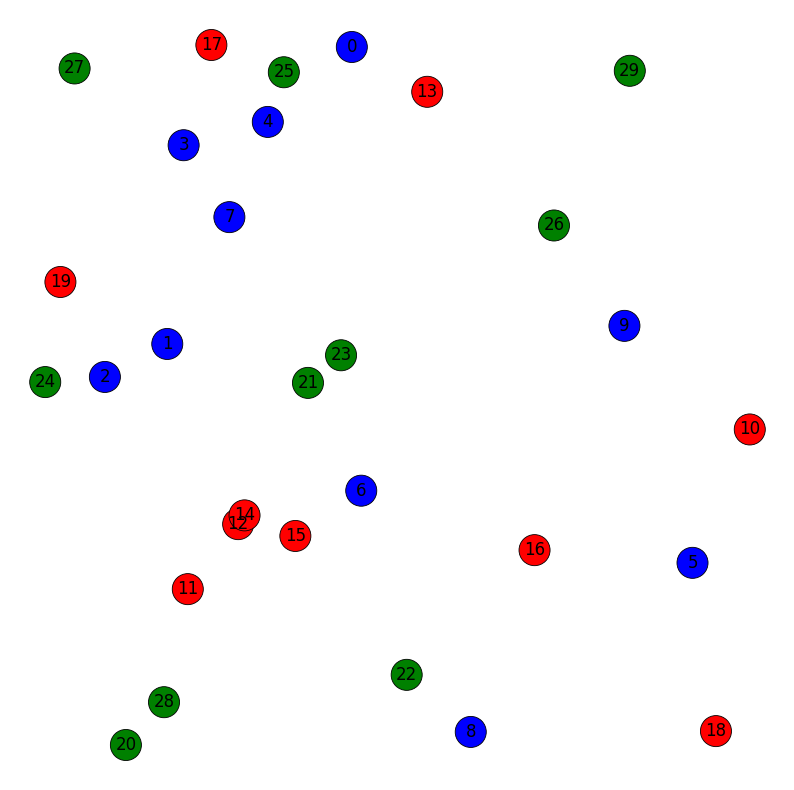

In [229]:
DrawInitG(G,(10,10), withedges=False)

In [230]:
G.edges(data=True)

EdgeDataView([(0, 20, {'a': 9.951183115743182, 'dist': 9.951183115743182}), (0, 21, {'a': 4.588435018329191, 'dist': 4.588435018329191}), (0, 22, {'a': 8.535666746389536, 'dist': 8.535666746389536}), (0, 23, {'a': 4.177222249984038, 'dist': 4.177222249984038}), (0, 24, {'a': 6.1982332687241435, 'dist': 6.1982332687241435}), (0, 25, {'a': 0.9969742512349629, 'dist': 0.9969742512349629}), (0, 26, {'a': 3.6867639707490993, 'dist': 3.6867639707490993}), (0, 27, {'a': 3.8288157930535376, 'dist': 3.8288157930535376}), (0, 28, {'a': 9.241891422047203, 'dist': 9.241891422047203}), (0, 29, {'a': 3.841624019389651, 'dist': 3.841624019389651}), (0, 10, {'t': 7.540550295510233, 'dist': 7.540550295510233}), (0, 11, {'t': 7.681341439940546, 'dist': 7.681341439940546}), (0, 12, {'t': 6.648382949268324, 'dist': 6.648382949268324}), (0, 13, {'t': 1.2028627675322907, 'dist': 1.2028627675322907}), (0, 14, {'t': 6.512474557103861, 'dist': 6.512474557103861}), (0, 15, {'t': 6.667003233040058, 'dist': 6.667

## Optimizing the model

In [231]:
#Creating the model
pcf = gb.Model('Primary care facility')

In [232]:
# je crois que c'est bon maintenant
# Variable decision x1, x1[k] = 1 if clinic k is established
x1 = pcf.addVars(index_of_clinic,vtype=gb.GRB.BINARY, name='x1')
# Variable decision x2, x2[j] = 1 if hospital j is established
x2 = pcf.addVars(index_of_hospitals,vtype=gb.GRB.BINARY, name='x2')
# Variable decision u, u[i][k] = number of patient who go to node i to clinic k
u = pcf.addVars([(i,k) for i in index_of_demand_points for k in index_of_clinic], lb = 0, obj=[G.edges[(i,k)]['dist'] for i in index_of_demand_points for k in index_of_clinic], 
                vtype=gb.GRB.INTEGER, name='u')
# Variable decision v, v[k][j] = number of patient who go to clinic k to hospital j
v = pcf.addVars([(k,j) for k in index_of_clinic for j in index_of_hospitals],lb = 0, obj=[G[k][j]['dist'] for k in index_of_clinic for j in index_of_hospitals], 
                vtype=gb.GRB.INTEGER, name='v')
pcf.update()
pcf.write('pcf.lp')


### Objective function

In [233]:
v.keys()

<gurobi.tuplelist (100 tuples, 2 values each):
 ( 0 , 10 )
 ( 0 , 11 )
 ( 0 , 12 )
 ( 0 , 13 )
 ( 0 , 14 )
 ( 0 , 15 )
 ( 0 , 16 )
 ( 0 , 17 )
 ( 0 , 18 )
 ( 0 , 19 )
 ( 1 , 10 )
 ( 1 , 11 )
 ( 1 , 12 )
 ( 1 , 13 )
 ( 1 , 14 )
 ( 1 , 15 )
 ( 1 , 16 )
 ( 1 , 17 )
 ( 1 , 18 )
 ( 1 , 19 )
 ( 2 , 10 )
 ( 2 , 11 )
 ( 2 , 12 )
 ( 2 , 13 )
 ( 2 , 14 )
 ( 2 , 15 )
 ( 2 , 16 )
 ( 2 , 17 )
 ( 2 , 18 )
 ( 2 , 19 )
 ( 3 , 10 )
 ( 3 , 11 )
 ( 3 , 12 )
 ( 3 , 13 )
 ( 3 , 14 )
 ( 3 , 15 )
 ( 3 , 16 )
 ( 3 , 17 )
 ( 3 , 18 )
 ( 3 , 19 )
 ( 4 , 10 )
 ( 4 , 11 )
 ( 4 , 12 )
 ( 4 , 13 )
 ( 4 , 14 )
 ( 4 , 15 )
 ( 4 , 16 )
 ( 4 , 17 )
 ( 4 , 18 )
 ( 4 , 19 )
 ( 5 , 10 )
 ( 5 , 11 )
 ( 5 , 12 )
 ( 5 , 13 )
 ( 5 , 14 )
 ( 5 , 15 )
 ( 5 , 16 )
 ( 5 , 17 )
 ( 5 , 18 )
 ( 5 , 19 )
 ( 6 , 10 )
 ( 6 , 11 )
 ( 6 , 12 )
 ( 6 , 13 )
 ( 6 , 14 )
 ( 6 , 15 )
 ( 6 , 16 )
 ( 6 , 17 )
 ( 6 , 18 )
 ( 6 , 19 )
 ( 7 , 10 )
 ( 7 , 11 )
 ( 7 , 12 )
 ( 7 , 13 )
 ( 7 , 14 )
 ( 7 , 15 )
 ( 7 , 16 )
 ( 7 , 17 )
 ( 7 , 18 )
 ( 7 

In [234]:
u.keys()

<gurobi.tuplelist (100 tuples, 2 values each):
 ( 20 , 0 )
 ( 20 , 1 )
 ( 20 , 2 )
 ( 20 , 3 )
 ( 20 , 4 )
 ( 20 , 5 )
 ( 20 , 6 )
 ( 20 , 7 )
 ( 20 , 8 )
 ( 20 , 9 )
 ( 21 , 0 )
 ( 21 , 1 )
 ( 21 , 2 )
 ( 21 , 3 )
 ( 21 , 4 )
 ( 21 , 5 )
 ( 21 , 6 )
 ( 21 , 7 )
 ( 21 , 8 )
 ( 21 , 9 )
 ( 22 , 0 )
 ( 22 , 1 )
 ( 22 , 2 )
 ( 22 , 3 )
 ( 22 , 4 )
 ( 22 , 5 )
 ( 22 , 6 )
 ( 22 , 7 )
 ( 22 , 8 )
 ( 22 , 9 )
 ( 23 , 0 )
 ( 23 , 1 )
 ( 23 , 2 )
 ( 23 , 3 )
 ( 23 , 4 )
 ( 23 , 5 )
 ( 23 , 6 )
 ( 23 , 7 )
 ( 23 , 8 )
 ( 23 , 9 )
 ( 24 , 0 )
 ( 24 , 1 )
 ( 24 , 2 )
 ( 24 , 3 )
 ( 24 , 4 )
 ( 24 , 5 )
 ( 24 , 6 )
 ( 24 , 7 )
 ( 24 , 8 )
 ( 24 , 9 )
 ( 25 , 0 )
 ( 25 , 1 )
 ( 25 , 2 )
 ( 25 , 3 )
 ( 25 , 4 )
 ( 25 , 5 )
 ( 25 , 6 )
 ( 25 , 7 )
 ( 25 , 8 )
 ( 25 , 9 )
 ( 26 , 0 )
 ( 26 , 1 )
 ( 26 , 2 )
 ( 26 , 3 )
 ( 26 , 4 )
 ( 26 , 5 )
 ( 26 , 6 )
 ( 26 , 7 )
 ( 26 , 8 )
 ( 26 , 9 )
 ( 27 , 0 )
 ( 27 , 1 )
 ( 27 , 2 )
 ( 27 , 3 )
 ( 27 , 4 )
 ( 27 , 5 )
 ( 27 , 6 )
 ( 27 , 7 )
 ( 27 , 8 )
 ( 27

In [235]:
theta

{0: 0.041688723218113455,
 1: 0.106136046213128,
 2: 0.20205944892453576,
 3: 0.9052871606494988,
 4: 0.854448991083441,
 5: 0.2496359616394519,
 6: 0.6027873845866969,
 7: 0.5328505334693014,
 8: 0.33027135874118674,
 9: 0.03467016201148132}

In [236]:
[u.sum('*',0)]

[<gurobi.LinExpr: u[20,0] + u[21,0] + u[22,0] + u[23,0] + u[24,0] + u[25,0] + u[26,0] + u[27,0] + u[28,0] + u[29,0]>]

In [237]:
[u.sum('*',k) for k in index_of_clinic]

[<gurobi.LinExpr: u[20,0] + u[21,0] + u[22,0] + u[23,0] + u[24,0] + u[25,0] + u[26,0] + u[27,0] + u[28,0] + u[29,0]>,
 <gurobi.LinExpr: u[20,1] + u[21,1] + u[22,1] + u[23,1] + u[24,1] + u[25,1] + u[26,1] + u[27,1] + u[28,1] + u[29,1]>,
 <gurobi.LinExpr: u[20,2] + u[21,2] + u[22,2] + u[23,2] + u[24,2] + u[25,2] + u[26,2] + u[27,2] + u[28,2] + u[29,2]>,
 <gurobi.LinExpr: u[20,3] + u[21,3] + u[22,3] + u[23,3] + u[24,3] + u[25,3] + u[26,3] + u[27,3] + u[28,3] + u[29,3]>,
 <gurobi.LinExpr: u[20,4] + u[21,4] + u[22,4] + u[23,4] + u[24,4] + u[25,4] + u[26,4] + u[27,4] + u[28,4] + u[29,4]>,
 <gurobi.LinExpr: u[20,5] + u[21,5] + u[22,5] + u[23,5] + u[24,5] + u[25,5] + u[26,5] + u[27,5] + u[28,5] + u[29,5]>,
 <gurobi.LinExpr: u[20,6] + u[21,6] + u[22,6] + u[23,6] + u[24,6] + u[25,6] + u[26,6] + u[27,6] + u[28,6] + u[29,6]>,
 <gurobi.LinExpr: u[20,7] + u[21,7] + u[22,7] + u[23,7] + u[24,7] + u[25,7] + u[26,7] + u[27,7] + u[28,7] + u[29,7]>,
 <gurobi.LinExpr: u[20,8] + u[21,8] + u[22,8] + u[23,8] 

In [238]:
index_of_clinic

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### Constraints

In [239]:
# verifier les range
pcf.addConstrs((u.sum(i, '*') == C[i] for i in index_of_demand_points), name='29')
pcf.addConstrs((v.sum(k, '*') == theta[k]*u.sum('*',k) for k in index_of_clinic), name='30')

pcf.addConstrs((u.sum('*', k) <= C[k]*x1[k] for k in index_of_clinic), name='31')
pcf.addConstrs((v.sum('*', j) <= C[j]*x2[j] for j in index_of_hospitals), name='32')

pcf.addConstr(x1.sum('*') == p , name='33')
pcf.addConstr(x2.sum('*') == q , name='34')

pcf.update()
pcf.write('pcf.lp')

# Domain constraints
# pcf.addConstrs((u[i,k] >= 0 for i in range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points) for k in range(number_of_clinic, number_of_clinic + number_of_hospitals)), name='35')
# pcf.addConstrs((v[k,j] >= 0 for k in range(number_of_clinic, number_of_clinic + number_of_hospitals) for j in range(0, number_of_clinic)), name='36')
# useless before be can define it 


In [240]:
totalcapacityclinic = 0
for k in index_of_clinic:
    totalcapacityclinic = totalcapacityclinic + C[k]
totalcapacityhospital = 0
for k in index_of_hospitals:
    totalcapacityhospital = totalcapacityhospital + C[k]
totaldemand = 0
for k in index_of_demand_points:
    totaldemand = totaldemand + C[k]
print(totalcapacityclinic)
print(totalcapacityhospital)
print(totaldemand)

1367
3106
190


In [241]:
pcf.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42 rows, 220 columns and 540 nonzeros
Model fingerprint: 0x60d45aa5
Variable types: 0 continuous, 220 integer (20 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+02]
  Objective range  [7e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 3 rows and 20 columns
Presolve time: 0.00s
Presolved: 39 rows, 200 columns, 490 nonzeros
Variable types: 0 continuous, 200 integer (10 binary)

Root relaxation: objective 5.258941e+02, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  525.89407    0    7          -  525.89407      -    

In [333]:
#Creating xfinal, the dict of all active edges

xfinal = dict(x)
xfinal.update(y)

#Removing the key from the dict if the value is 0, e.G the edge isn't active
for xtuple in list(xfinal) :
    if xfinal[xtuple].x != 1 :
        xfinal.pop(xtuple, None)

NameError: name 'x' is not defined

In [332]:
DrawSol(G, (10,10), x)

NameError: name 'x' is not defined

In [36]:
# supposed that a city is a circle of 5 km radius
d_ik = {i:random.randint(10,5000) #distance between 10 meters and 5 km
        for i in I}

d_kj = {k:random.randint(10,2000) #distance between 10 meters and 2 km
        for k in K}

w = {i:random.randint(0,100) # population in node i
        for i in I}

# on peut aussi dire que tous les hopitaux et cliniques ont la même capacité d'accueil
C1 = {k:random.randint(20,100) # a clinic can accommodate between 20 and 100 people
        for k in K}

C2 = {j:random.randint(100,300) # an hospital can accommodate between 100 and 300 people
        for j in J}

# number of clinic and hospital based on the number in Nantes
p = 5
q = 5

In [37]:
d_ik

{1: 3000,
 2: 2054,
 3: 985,
 4: 619,
 5: 366,
 6: 108,
 7: 515,
 8: 3363,
 9: 803,
 10: 4141,
 11: 1122,
 12: 4879,
 13: 4454,
 14: 1296,
 15: 2286,
 16: 2106,
 17: 505,
 18: 2238,
 19: 69,
 20: 2015,
 21: 2348,
 22: 4442,
 23: 1661,
 24: 958,
 25: 2921,
 26: 2104,
 27: 3248,
 28: 2462,
 29: 3099,
 30: 716,
 31: 198,
 32: 4898,
 33: 2370,
 34: 3740,
 35: 3298,
 36: 296,
 37: 3646,
 38: 1586,
 39: 1038,
 40: 919,
 41: 3780,
 42: 1221,
 43: 470,
 44: 1097,
 45: 3567,
 46: 1079,
 47: 1794,
 48: 533,
 49: 3494,
 50: 389}

In [38]:
d_kj

{1: 737, 2: 1840, 3: 952, 4: 1487, 5: 566, 6: 793, 7: 586, 8: 98, 9: 1997}

In [39]:
G.nodes(data=True)

NodeDataView({1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}})

In [40]:
for i in I:
    for k in K:
        G.add_edge(i,"clinic", dist = d_ik[i])

In [41]:
print (G.edges(data=True))

[(1, 'clinic', {'dist': 3000}), (2, 'clinic', {'dist': 2054}), (3, 'clinic', {'dist': 985}), (4, 'clinic', {'dist': 619}), (5, 'clinic', {'dist': 366}), (6, 'clinic', {'dist': 108}), (7, 'clinic', {'dist': 515}), (8, 'clinic', {'dist': 3363}), (9, 'clinic', {'dist': 803}), (10, 'clinic', {'dist': 4141}), (11, 'clinic', {'dist': 1122}), (12, 'clinic', {'dist': 4879}), (13, 'clinic', {'dist': 4454}), (14, 'clinic', {'dist': 1296}), (15, 'clinic', {'dist': 2286}), (16, 'clinic', {'dist': 2106}), (17, 'clinic', {'dist': 505}), (18, 'clinic', {'dist': 2238}), (19, 'clinic', {'dist': 69}), (20, 'clinic', {'dist': 2015}), (21, 'clinic', {'dist': 2348}), (22, 'clinic', {'dist': 4442}), (23, 'clinic', {'dist': 1661}), (24, 'clinic', {'dist': 958}), (25, 'clinic', {'dist': 2921}), (26, 'clinic', {'dist': 2104}), (27, 'clinic', {'dist': 3248}), (28, 'clinic', {'dist': 2462}), (29, 'clinic', {'dist': 3099}), (30, 'clinic', {'dist': 716}), (31, 'clinic', {'dist': 198}), (32, 'clinic', {'dist': 4898

In [20]:
for k in K:
    for j in J:
        G.add_edge(k,j, dist = d_kj[k])

In [21]:
print (G.edges(data=True))

[(1, 1, {'dist': 266}), (1, 2, {'dist': 266}), (1, 3, {'dist': 266}), (1, 4, {'dist': 266}), (1, 5, {'dist': 266}), (1, 6, {'dist': 266}), (1, 7, {'dist': 266}), (1, 8, {'dist': 266}), (1, 9, {'dist': 266}), (2, 1, {'dist': 495}), (2, 2, {'dist': 495}), (2, 3, {'dist': 495}), (2, 4, {'dist': 495}), (2, 5, {'dist': 495}), (2, 6, {'dist': 495}), (2, 7, {'dist': 495}), (2, 8, {'dist': 495}), (2, 9, {'dist': 495}), (3, 1, {'dist': 1603}), (3, 2, {'dist': 1603}), (3, 3, {'dist': 1603}), (3, 4, {'dist': 1603}), (3, 5, {'dist': 1603}), (3, 6, {'dist': 1603}), (3, 7, {'dist': 1603}), (3, 8, {'dist': 1603}), (3, 9, {'dist': 1603}), (4, 1, {'dist': 600}), (4, 2, {'dist': 600}), (4, 3, {'dist': 600}), (4, 4, {'dist': 600}), (4, 5, {'dist': 600}), (4, 6, {'dist': 600}), (4, 7, {'dist': 600}), (4, 8, {'dist': 600}), (4, 9, {'dist': 600}), (5, 1, {'dist': 727}), (5, 2, {'dist': 727}), (5, 3, {'dist': 727}), (5, 4, {'dist': 727}), (5, 5, {'dist': 727}), (5, 6, {'dist': 727}), (5, 7, {'dist': 727}), (

In [10]:
G.nodes(data=True)

NodeDataView({1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}})

In [11]:
pos = nx.shell_layout(G)
edge_lab = {(i,j):[G[i][j]['dist']] for i, j in G.edges()}



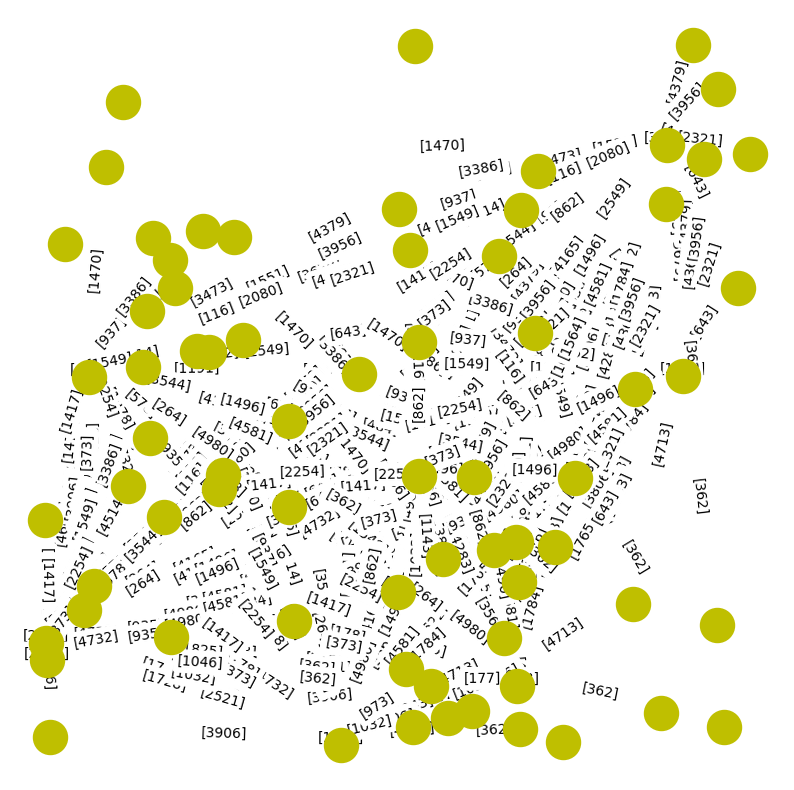

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))


nx.draw_networkx_edge_labels (G, pos, label_pos=0.4, edge_labels=edge_lab, verticalalignment='bottom')
# nx.draw_networkx_labels (G,pos, labels=node_lab)

nx.draw(G, pos, ax, with_labels=False, node_size=600, node_color='y')

### Variables

In [ ]:
pcf = gb.Model('Primary care facility')

In [ ]:
x = pcf.addVars(G.edges(),vtype=gb.GRB.CONTINUOUS, name='x')

In [ ]:
u = pcf.addVars(G.edges(), 
                        vtype=gb.GRB.BINARY, 
                        name='y')

In [ ]:
pcf.update()
pcf.write('pcf.lp')

### Objective function

In [ ]:
pcf.setObjective(y.prod(nx.get_edge_attributes(G, 'activation')), \
                         gb.GRB.MINIMIZE)